# Text Compression: Semantic Approach

- **Created by Andrés Segura Tinoco**  
- **Created on August 20, 2019**

**Natural language processing (NLP):** is a discipline where computer science, artificial intelligence and cognitive logic are intercepted, with the objective that machines can read and understand our language for decision making <a href="#link_one">[1]</a>.

In [1]:
# Load Python libraries
import io
import os
import pandas as pd
from collections import Counter

In [2]:
# Load Plot libraries
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## 1. Semantic Compression (SC)
Below, the proposed procedure with a **NLP** approach to text preprocessing:
- Read the plain text file in unicode format
- Find the heaviest words: (frequency * length)
- Find the unused symbols from the possible bytes [0, 255]
- Apply semantic compression: replace heavier words with unused symbols
- Save compressed file with semantic table attached
- Show the new byte distribution

### Step 1 - Read the plain text file

In [3]:
# Set local file encoding
file_enconding = 'utf8'

In [4]:
# Util function to read a plain text file
def read_text_file(file_path):
    text = ""
    
    if os.path.isfile(file_path):
        print('Read the following file:', file_path)
        with io.open(file_path, 'r', encoding = file_enconding) as f:
            text = f.read()
    
    return text

In [5]:
# Util function to save a plain text file
def save_text_file(file_path, text):
    try:
        with open(file_path, 'w', encoding = file_enconding) as f:
            f.write(text)
    except:
        print("Error saving text file:", file_path)
        return False
    
    return True

In [6]:
# Loading target text book
file_path = "../data/text/book1-en.txt"
file_text1 = read_text_file(file_path)

Read the following file: ../data/text/book1-en.txt


In [7]:
# Weight of the original file
file_size = os.path.getsize(file_path)
print('Original file size:', round(file_size / 1024, 2), 'KB')

Original file size: 1227.64 KB


### Step 2 - Find the Heaviest Words

In [8]:
# Cleaing the plain text
clean_text = file_text1.replace('\n', ' ')
clean_text = clean_text.replace('. ', ' ')
clean_text = clean_text.replace(', ', ' ')
clean_text = clean_text.replace('; ', ' ')
clean_text = clean_text.replace('! ', ' ')

**Note:** Experimentally it was found that passing the plain-text through a data quality process adds approximately 1% more data compression.

In [9]:
# Tokenize text in a words list
word_list = clean_text.split(' ')
print('Number of words:', len(word_list))

Number of words: 216910


In [10]:
# Showing first 100 words
print(word_list[:100])

['\ufeff', 'The', 'Project', 'Gutenberg', 'EBook', 'of', 'Moby', 'Dick', 'or', 'The', 'Whale', 'by', 'Herman', 'Melville', '', 'This', 'eBook', 'is', 'for', 'the', 'use', 'of', 'anyone', 'anywhere', 'at', 'no', 'cost', 'and', 'with', 'almost', 'no', 'restrictions', 'whatsoever', '', 'You', 'may', 'copy', 'it', 'give', 'it', 'away', 'or', 're-use', 'it', 'under', 'the', 'terms', 'of', 'the', 'Project', 'Gutenberg', 'License', 'included', 'with', 'this', 'eBook', 'or', 'online', 'at', 'www.gutenberg.org', '', '', 'Title:', 'Moby', 'Dick', 'or', 'The', 'Whale', '', 'Author:', 'Herman', 'Melville', '', 'Release', 'Date:', 'December', '25', '2008', '[EBook', '#2701]', 'Last', 'Updated:', 'December', '3', '2017', '', 'Language:', 'English', '', 'Character', 'set', 'encoding:', 'UTF-8', '', '***', 'START', 'OF', 'THIS', 'PROJECT', 'GUTENBERG']


In [11]:
# Get the most common words in the document
n_words = Counter(word_list).most_common(1000)
df_words = pd.DataFrame.from_records(n_words, columns = ['word', 'quantity'])
df_words['comp_size'] = df_words.quantity * df_words.word.str.len()
df_words = df_words.sort_values(by=['comp_size'], ascending=False)
df_words.head(10)

,word,quantity,comp_size
0,the,13697,41091
2,and,6003,18009
1,of,6563,13126
7,that,2816,11264
3,to,4509,9018
6,in,3903,7806
8,his,2456,7368
12,with,1663,6652
19,this,1225,4900
13,was,1623,4869


Show the 50 Most Common Words in document.

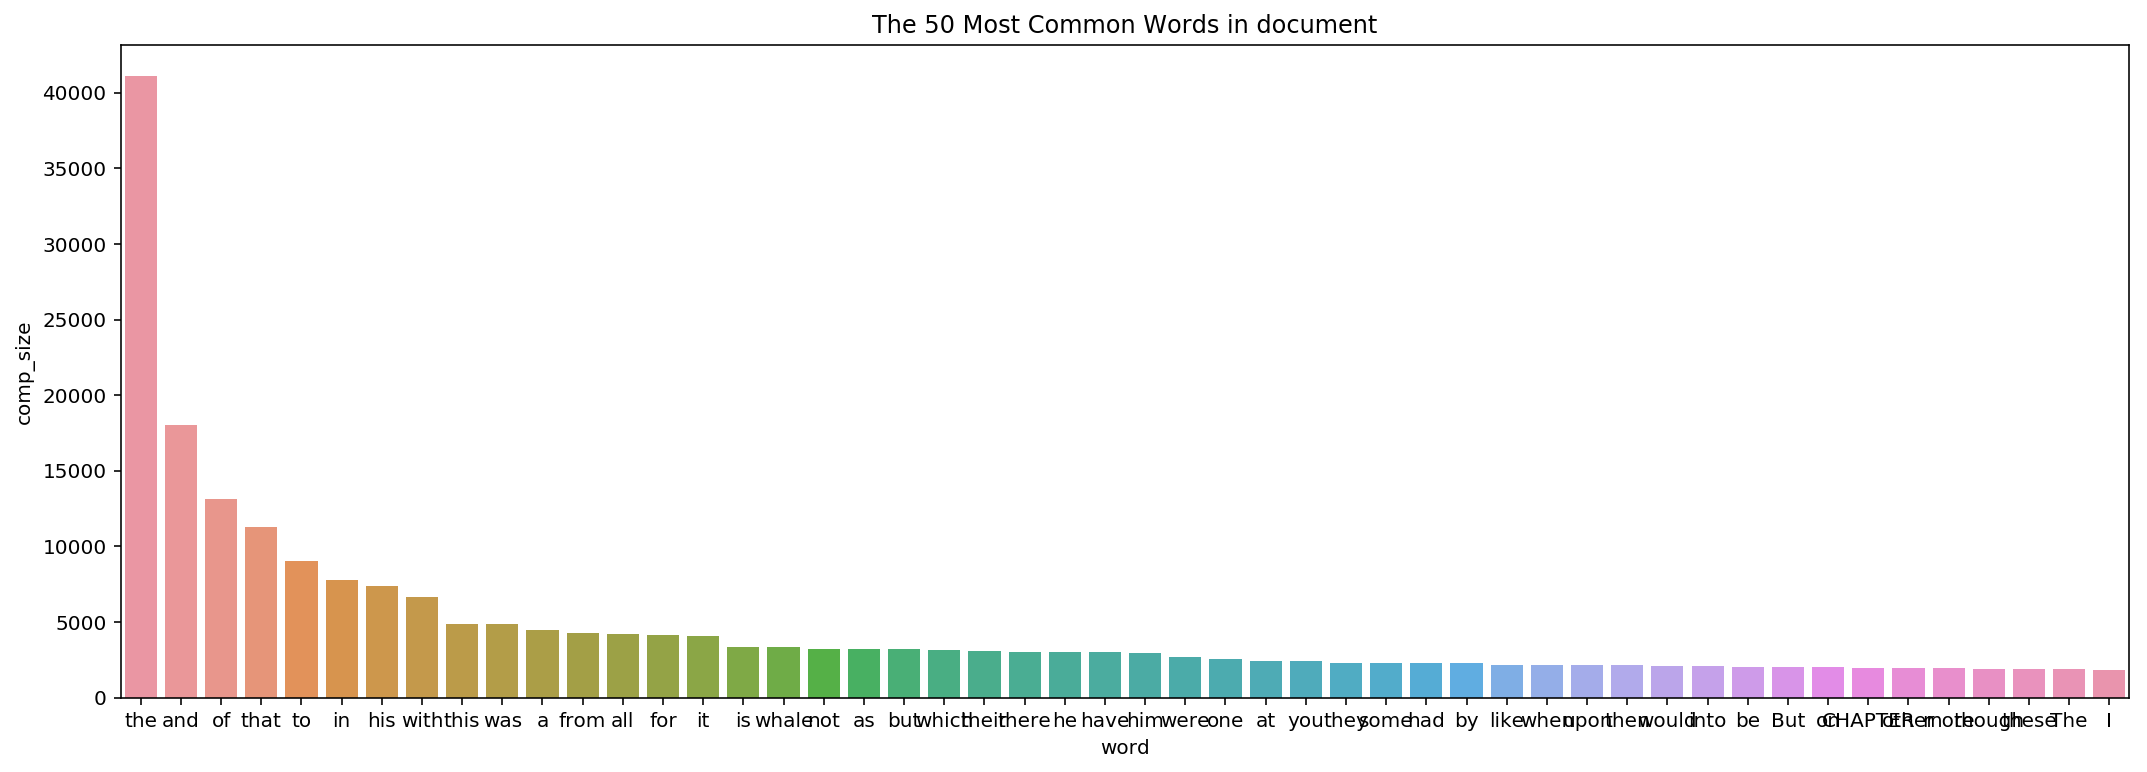

In [12]:
# Plot the most common words in the document
fig = plt.figure(figsize = (18, 6))
sns.barplot(x = 'word', y = 'comp_size', data = df_words[0:50])
plt.title('The 50 Most Common Words in document')
plt.show()

### Step 3 - Find the Unused Symbols
Once the words to be replaced are identified, the unused symbols must be found in the alphabet, to be used as substituents.

In [13]:
# Read file in low level (Bytes)
def get_file_bytes(file_path):
    with open(file_path, 'rb') as f:
        return bytearray(f.read());
    return None;

In [14]:
# Loading target text book
file_byte_list = get_file_bytes(file_path)

In [15]:
# Calculate code frequency
term_freq = Counter(file_byte_list)
n = len(term_freq)
print('Unique symbols used:', n)

Unique symbols used: 110


In [16]:
# Normalize term frequency
max_symbols = 256
total = sum(term_freq.values())

for ix in range(max_symbols):
    if ix in term_freq:
        term_freq[ix] = term_freq[ix] / total
    else:
        term_freq[ix] = 0

In [17]:
# Create dataframe: unused byte list
df_ubytes = pd.DataFrame.from_records(term_freq.most_common(max_symbols), columns = ['byte', 'frequency'])
df_ubytes['symbol'] = [chr(b) for b in df_ubytes.byte]
df_ubytes = df_ubytes[['byte', 'symbol', 'frequency']]
df_ubytes.head(10)

,byte,symbol,frequency
0,32,,0.155075
1,101,e,0.092954
2,116,t,0.068523
3,97,a,0.060395
4,111,o,0.054837
5,110,n,0.051702
6,115,s,0.049752
7,105,i,0.049692
8,104,h,0.049322
9,114,r,0.041215


In [18]:
# Create pretty x axis labels
def get_x_labels():
    x_labels = []
    for ix in range(max_symbols):
        if ix % 5 == 0:
            x_labels.append(str(ix))
        else:
            x_labels.append('')
    return x_labels

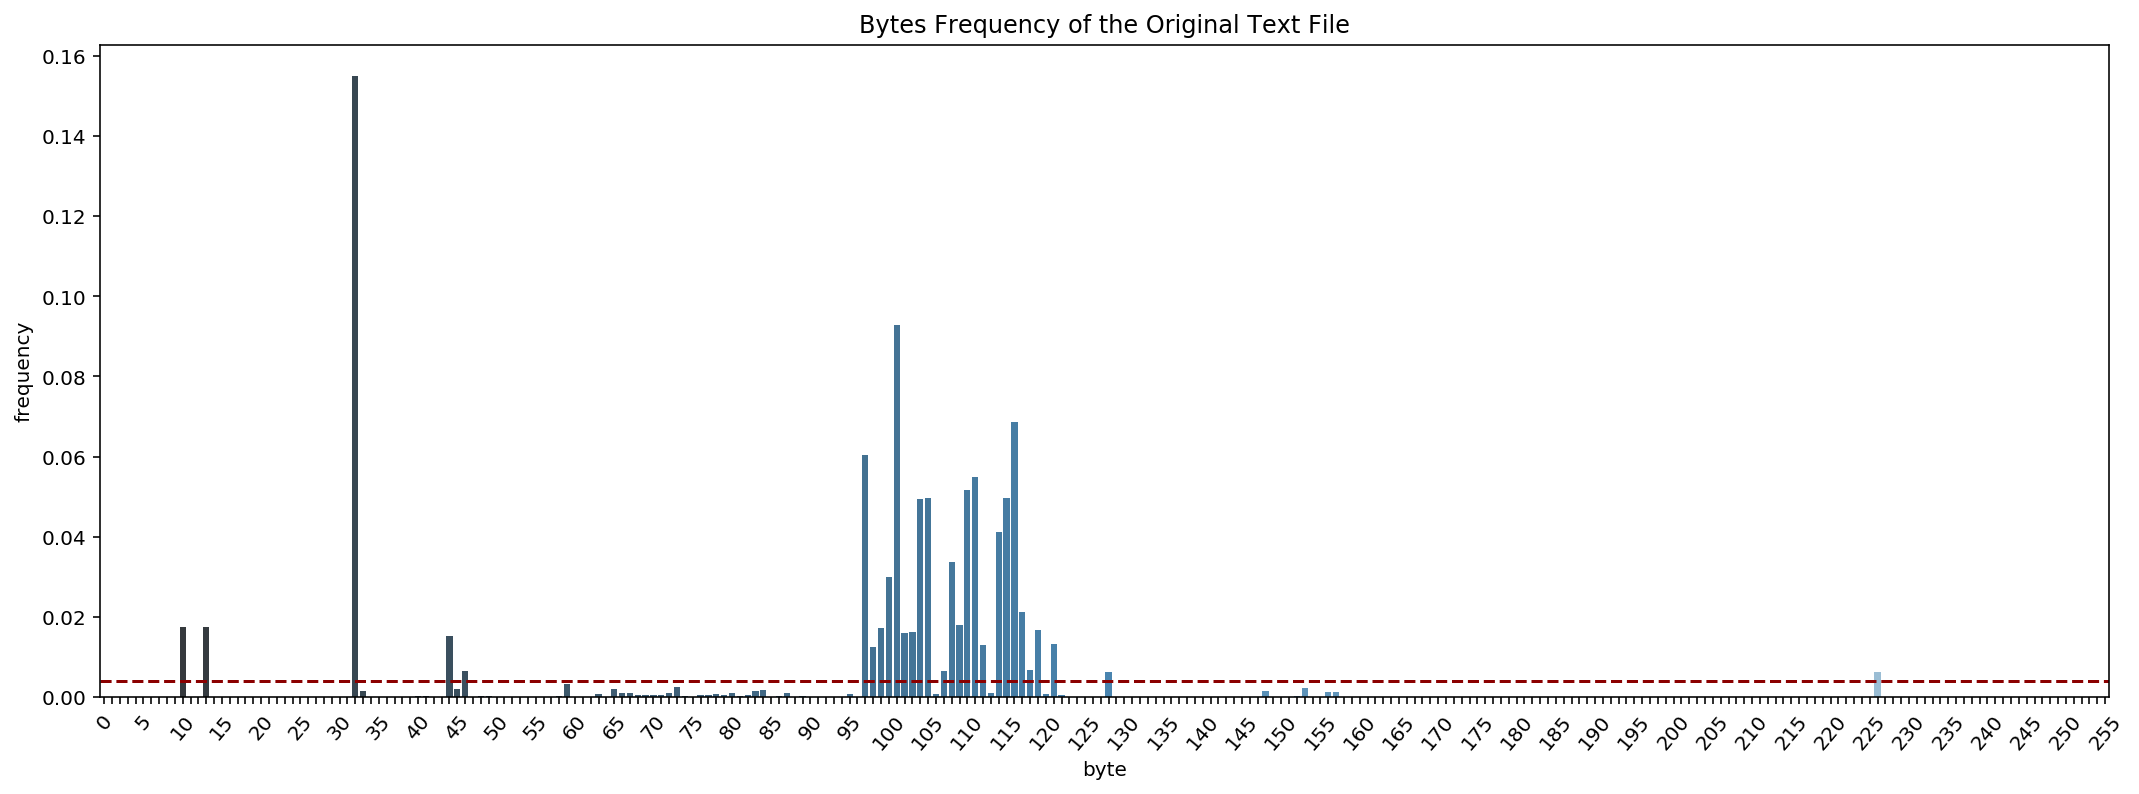

In [19]:
# Probability of each symbol by default
p_x = 1 / max_symbols

# Plot the frequency of the bytes in the file
fig = plt.figure(figsize = (18, 6))
ax = sns.barplot(x = 'byte', y = 'frequency', data = df_ubytes.sort_values(by=['byte']), palette=("Blues_d"))
ax.set_xticklabels(labels = get_x_labels(), fontsize = 10, rotation = 50)
plt.axhline(y = p_x, color = "#8b0000", linestyle = "--")
plt.title('Bytes Frequency of the Original Text File')
plt.show()

In [20]:
# Get locked symbols
locked_symbols = []
two_bytes_symb = [chr(c) for c in range(128, max_symbols)]

for spe_sym in two_bytes_symb:
    if spe_sym in file_text1:
        locked_symbols.append(spe_sym)

locked_symbols

['£', 'â', 'æ', 'è', 'é']

In [21]:
# Save unused symbols
unused_symbols = list(df_ubytes[df_ubytes['frequency'] == 0]["byte"])
unused_symbols = list(set(unused_symbols) - set([ord(ls) for ls in locked_symbols]))
len(unused_symbols)

143

Now, we can replace the heaviest words with unused symbols in the file.

In [22]:
# Returns the semantic table with the new symbols to replace the heaviest words
def get_semantic_table(df_words, unused_symbols):
    new_symbols = dict()
    n_symb_repleced = min(150, len(unused_symbols))
    ix = 0

    for index, row in df_words.iterrows():
        if len(row['word']) > 1:
            key = row['word']
            value = int(unused_symbols[ix])
            new_symbols[key] = value
            ix += 1
        
        if ix == n_symb_repleced:
            break
    
    return new_symbols

In [23]:
# Show semantic table
semantic_table = get_semantic_table(df_words, unused_symbols)
print(semantic_table)

{'the': 0, 'and': 1, 'of': 2, 'that': 3, 'to': 4, 'in': 5, 'his': 6, 'with': 7, 'this': 8, 'was': 9, 'from': 11, 'all': 12, 'for': 14, 'it': 15, 'is': 16, 'whale': 17, 'not': 18, 'as': 19, 'but': 20, 'which': 21, 'their': 22, 'there': 23, 'he': 24, 'have': 25, 'him': 26, 'were': 27, 'one': 28, 'at': 29, 'you': 30, 'they': 31, 'some': 34, 'had': 37, 'by': 39, 'like': 43, 'when': 47, 'upon': 60, 'then': 61, 'would': 62, 'into': 64, 'be': 92, 'But': 94, 'on': 96, 'CHAPTER': 123, 'other': 124, 'more': 125, 'though': 126, 'these': 127, 'The': 129, 'them': 131, 'so': 133, 'now': 134, 'are': 135, 'before': 136, 'seemed': 137, 'been': 138, 'over': 139, 'Ahab': 140, 'through': 141, 'what': 142, 'Queequeg': 143, 'out': 144, 'will': 145, 'those': 150, 'about': 154, 'little': 155, 'still': 158, 'great': 159, 'ship': 160, 'only': 161, 'or': 164, 'down': 165, 'whales': 167, 'himself': 170, 'such': 171, 'Captain': 172, 'old': 173, 'Starbuck': 174, 'time': 175, 'very': 177, 'than': 178, 'after': 179, 

### Step 4 - Apply Semantic Compression (SC)

In [24]:
# Function that applies a semantic compression approach
def compress_text(curr_text, codes, forward = True):
    symbol_list = sorted([(len(k), k, v) for k, v in codes.items()], key = lambda x: int(x[0]), reverse = True)
    new_text = curr_text

    for l, key, value in symbol_list:
        c_value = chr(value)
        if forward:
            new_text = new_text.replace(key, c_value)
        else:
            new_text = new_text.replace(c_value, key)
    
    return new_text

In [25]:
# Compressiong text of the file
file_text_comp = compress_text(file_text1, semantic_table)

### Step 5 - Save Compressed File

In [26]:
file_path_comp = file_path.replace('.txt', '_comp.txt')
save_text_file(file_path_comp, file_text_comp)

True

In [27]:
# Weight of the compressed file
file_size = os.path.getsize(file_path_comp)
print('Compressed file size:', round(file_size / 1024, 2), 'KB')

Compressed file size: 958.99 KB


In [28]:
# Original file
print('Number of characters:', len(file_text1))

Number of characters: 1219570


In [29]:
# Compressed file
print('Number of characters:', len(file_text_comp))

Number of characters: 889494


In [30]:
# Semantic compression percentage
compress_rate =  (len(file_text1) - len(file_text_comp)) / len(file_text1)
print('Compression Rate:', round(compress_rate * 100, 2), '%')

Compression Rate: 27.06 %


Click in the following link to download the compressed text file:

https://raw.githubusercontent.com/ansegura7/DataCompression/master/data/text/book1-en_comp.txt

### Step 6 - Show new Byte Distribution

In [31]:
# Loading target text book
file_byte_list = get_file_bytes(file_path_comp)

In [32]:
# Calculate code frequency
term_freq = Counter(file_byte_list)
n = len(term_freq)
print('Unique symbols used:', n)

Unique symbols used: 200


In [33]:
# Normalize term frequency
total = sum(term_freq.values())
for ix in range(max_symbols):
    if ix in term_freq:
        term_freq[ix] = term_freq[ix] / total
    else:
        term_freq[ix] = 0

In [34]:
# Create dataframe: unused byte list
df_ubytes = pd.DataFrame.from_records(term_freq.most_common(max_symbols), columns = ['byte', 'frequency'])
df_ubytes['symbol'] = [chr(b) for b in df_ubytes.byte]
df_ubytes = df_ubytes[['byte', 'symbol', 'frequency']]
df_ubytes.head(10)

,byte,symbol,frequency
0,32,,0.198516
1,101,e,0.059533
2,115,s,0.038495
3,194,Â,0.034089
4,114,r,0.033947
5,97,a,0.032637
6,108,l,0.029093
7,116,t,0.027243
8,100,d,0.024705
9,13,\r,0.022367


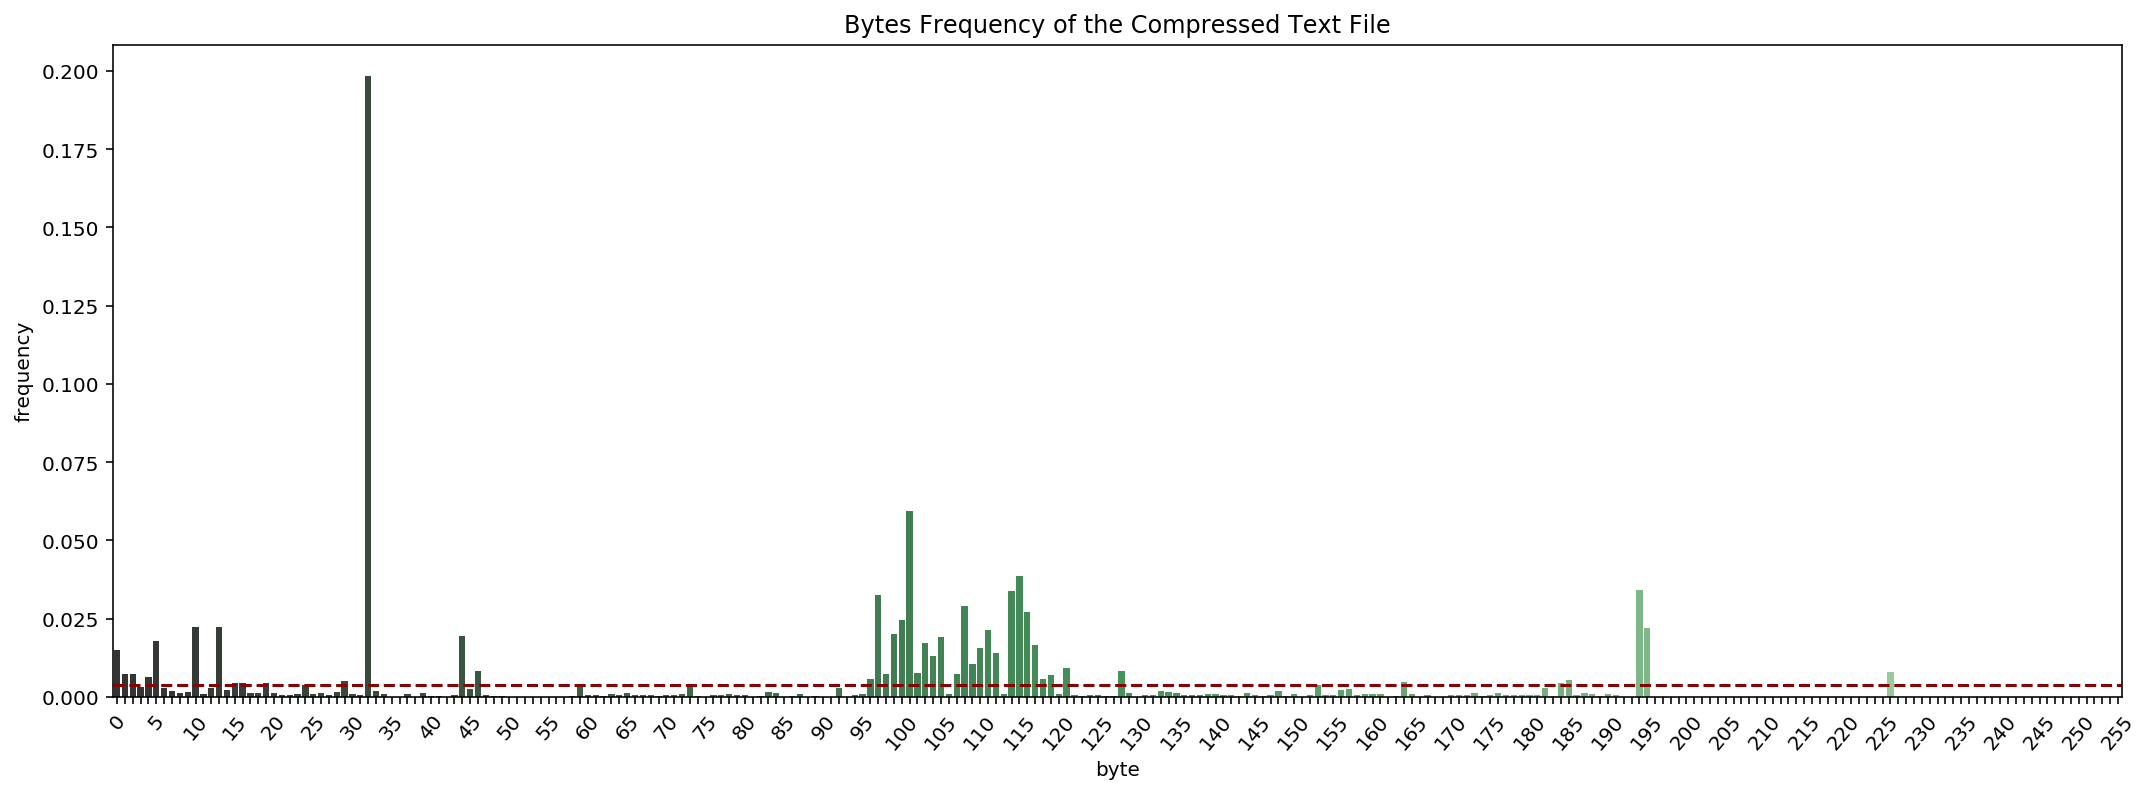

In [35]:
# Plot the frequency of the bytes in the file
fig = plt.figure(figsize = (18, 6))
ax = sns.barplot(x = 'byte', y = 'frequency', data = df_ubytes.sort_values(by=['byte']), palette=("Greens_d"))
ax.set_xticklabels(labels = get_x_labels(), fontsize = 10, rotation = 50)
plt.axhline(y = p_x, color = "#8b0000", linestyle = "--")
plt.title('Bytes Frequency of the Compressed Text File')
plt.show()

**Note:** The symbol 32 (in decimal) refers to the white space character of the <a href="http://www.asciitable.com/" target="_blank">ASCII</a> table.

## 2. Decompression and Validation

In [36]:
# Loading target text book
file_text_comp = read_text_file(file_path_comp)

Read the following file: ../data/text/book1-en_comp.txt


In [37]:
# Function that applies a semantic decompression approach
def decompress_text(comp_text, codes):
    new_text = compress_text(comp_text, codes, False)
    return new_text

In [38]:
# Decompression
file_text2 = decompress_text(file_text_comp, semantic_table)

In [39]:
# Compressed file
print('Number of characters:', len(file_text2))

Number of characters: 1219570


**Validation**

In [40]:
# Comparing size
len(file_text1) - len(file_text2)

0

In [41]:
# Comparing content
file_text1 == file_text2

True

## Reference

<a name="link_one" href="https://en.wikipedia.org/wiki/Natural_language_processing" target="_blank">[1]</a> Wikipedia - Natural language processing.

<hr>
<p><a href="https://ansegura7.github.io/DataCompression/">« Home</a></p>